#### **MARINE MICROPLASTICS : SPATIO-TEMPORAL ANALYSIS**

##### **Objectives:**


<div style="font-size:16px;">
<ol type="1">
<li>Exploratory Data Analysis (EDA) : </li>
    <ol>
    <li>To visualize and perform a statistical study of the data, including mean, median, and standard deviation for Microplastic Density and distriution across Oceans and Regions. 
    <li>To find correlation of variables like Microplastic Density measurement, Microplastic Material density range, and coordinates (latitude, longitude).
    </ol>
</br>
<li>GeoSpatial Analysis - Microplastic Hotspots Identification : To identify regions and subregions with a higher concentration of microplastic based on the density class.</li>
</br>
<li>Time Series Analysis of Density Distribution : 
    <ol><li>To study trends in density over time, by region or subregions and sampling methods.</li>
    <li>To develop a time series forecasting model to predict future measurements or density classes.</li></ol>
<br>
<li>Anomaly Detection : To identify spatial outliers where environmental conditions (e.g., measurements, density) are significantly different from neighboring areas, potentially indicating unusual phenomena or errors in the data.</li>
</ol>

</div>

In [18]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd
import folium
from folium.plugins import BeautifyIcon
from shapely.geometry import Point
import branca.colormap as cm
from branca.colormap import LinearColormap
from matplotlib.colors import LinearSegmentedColormap
from tabulate import tabulate
from folium import Map, Marker, Icon
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
import warnings
warnings.simplefilter('ignore')


##### **Dataset Overview**

<p style="font-size:16px;">
This dataset is extracted from National Centers for Environment Informations' Microsplastics Application (A GIS-based map portal). It contains aggregated global data on microplastics in marine settings. <br>

The dataset includes the following key columns: </p>


<div style="font-size:14px;">

| **Data Field**       | **Metadata**                                    |  
|-----------------------|------------------------------------------------|  
| **OBJECTID**          | Unique identifier for each microplastic record |  
| **Oceans**            | Name of the ocean where the sample was collected |  
| **Regions**           | Region within the ocean                        |  
| **SubRegions**        | Subregion within the region                    |  
| **Sampling Method**   | Method employed to collect the sample          |  
| **Measurement**       | Microplastic density measurement               |  
| **Unit**              | Unit of the measurement                        |  
| **MPM* Density Range**| Range of the microplastic material's density   |  
| **MPM* Density Class**| Microplastic material's density classification |  
| **Short Reference**   | Reference of the Study                         |  
| **Organization**      | Org. responsible for data collection           |  
| **Keywords**          | Keywords related to the study                  |  
| **Accession Number**  | Accession number for the data record           |  
| **Accession Link**    | Link to the data record                        |  
| **Latitude**          | Latitude of the sample location                |  
| **Longitude**         | Longitude of the sample location               |  
| **Date**              | Sample Collection Date                         |  
| **GlobalID**          | Global identifier for the record               |  
| **x**                 | X-coordinate of the sample location            |  
| **y**                 | Y-coordinate of the sample location            |  

</div>



<p style="font-size:13px;"> <i> MPM* Stands for Microplastic Material </i> </p>

##### **Exploratory Data Analysis (EDA)**


In [2]:
# Add a column to identify the Marine Setting of the object. 
df_ocean = pd.read_csv("../data/Marine_Microplastics_Ocean-Water.csv")  
df_ocean_sed = pd.read_csv("../data/Marine_Microplastics_Ocean-Sediment.csv")
df_beach = pd.read_csv("../data/Marine_Microplastics_Beach.csv")
df_beach_np = pd.read_csv("../data/Marine_Microplastics_Beach-Nurdle-Patrol.csv")
df_ocean['Marine Setting'] = "Ocean"
df_ocean_sed['Marine Setting'] = "Ocean Sediment"
df_beach['Marine Setting'] = df_beach_np['Marine Setting'] = "Beach"
df = pd.concat([df_ocean, df_ocean_sed, df_beach, df_beach_np], ignore_index=True)

df = df.rename(columns={'Density Range':'MPM Density Range', 'Density Class':'MPM Density Class'})
#display first five rows of the dataframe + metadata. 
display(df.head(5)) 


,OBJECTID,Oceans,Regions,SubRegions,Sampling Method,Measurement,Unit,MPM Density Range,MPM Density Class,Short Reference,...,Keywords,Accession Number,Accession Link,Latitude,Longitude,Date,GlobalID,x,y,Marine Setting
0,1729,Atlantic Ocean,NaN,NaN,Neuston net,0.00432,pieces/m3,0.0005-0.005,Low,Law et al.2010,...,SEA,211007,https://www.ncei.noaa.gov/access/metadata/land...,24.10,-82.88,1/5/2000 12:00:00 AM,4186099f-d428-4d0f-a4bf-bb70af93d2ab,-82.88,24.10,Ocean
1,1730,Atlantic Ocean,NaN,NaN,Neuston net,0.00216,pieces/m3,0.0005-0.005,Low,Law et al.2010,...,SEA,211007,https://www.ncei.noaa.gov/access/metadata/land...,24.24,-81.86,1/6/2000 12:00:00 AM,5fa6ab9d-3369-44cc-a0de-3c553a979085,-81.86,24.24,Ocean
2,1731,Atlantic Ocean,NaN,NaN,Neuston net,0.00216,pieces/m3,0.0005-0.005,Low,Law et al.2010,...,SEA,211007,https://www.ncei.noaa.gov/access/metadata/land...,24.24,-81.86,1/6/2000 12:00:00 AM,671db08b-f018-47ad-8109-098f9b10b02e,-81.86,24.24,Ocean
3,1732,Atlantic Ocean,NaN,NaN,Neuston net,0.00000,pieces/m3,0-0.0005,Very Low,Law et al.2010,...,SEA,211007,https://www.ncei.noaa.gov/access/metadata/land...,24.24,-81.83,1/6/2000 12:00:00 AM,0833bcaa-0050-467b-8140-5aef8c6886dd,-81.83,24.24,Ocean
4,1733,Atlantic Ocean,NaN,NaN,Neuston net,0.00000,pieces/m3,0-0.0005,Very Low,Law et al.2010,...,SEA,211007,https://www.ncei.noaa.gov/access/metadata/land...,24.24,-81.83,1/6/2000 12:00:00 AM,83d3ddff-faf4-4ef7-b6b7-358c37bdedb5,-81.83,24.24,Ocean


In [3]:
# Clean the dataset by removing rows with no Measurement specified.
df = df.dropna(subset = ['Measurement'])

# Convert 'Date' from Object to DateTime type and create corresponding year and month fields. 
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Month'] = pd.DatetimeIndex(df['Date']).month
df['Year-Month'] = df['Date'].dt.to_period('M')

# find median mpm density range
df_split = df['MPM Density Range'].str.split(r'-|<=|>=', expand=True)
df_split.columns = ['Min Density', 'Max Density']
df_split['Min Density'] = pd.to_numeric(df_split['Min Density'], errors='coerce')
df_split['Max Density'] = pd.to_numeric(df_split['Max Density'], errors='coerce')
df['Median Density'] = df_split[['Min Density', 'Max Density']].mean(axis=1)
df.info()
#df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 11950 entries, 0 to 11949
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   OBJECTID           11950 non-null  int64         
 1   Oceans             11950 non-null  object        
 2   Regions            4275 non-null   object        
 3   SubRegions         1441 non-null   object        
 4   Sampling Method    11950 non-null  object        
 5   Measurement        11950 non-null  float64       
 6   Unit               11950 non-null  object        
 7   MPM Density Range  11950 non-null  object        
 8   MPM Density Class  11950 non-null  object        
 9   Short Reference    11950 non-null  object        
 10  Long Reference     11950 non-null  object        
 11  DOI                11950 non-null  object        
 12  Organization       11950 non-null  object        
 13  Keywords           11716 non-null  object        
 14  Accession N

In [4]:
# df.loc[df['Unit']=="pieces kg-1 d.w.", 'Marine Setting'] #to confirm the validity of the Marine Setting value against the unit.  



In [5]:
# Number of microplastic records in each ocean.
print("Number of microplastic records in each ocean.\n")
# Group by 'Oceans' and get the size of each group
tot_records = pd.DataFrame(df.groupby('Oceans').size())

# Rename the column to something more meaningful (e.g., 'Record Count')
tot_records.columns = ['Total MP records']

# Apply the background gradient
tot_records_styled = tot_records.style.background_gradient(cmap='magma')

# Display the styled DataFrame
tot_records_styled
#df.head()

Number of microplastic records in each ocean.



,Total MP records
Oceans,
Arctic Ocean,310
Atlantic Ocean,5894
Indian Ocean,637
Pacific Ocean,5082
Southern Ocean,27


In [6]:
# measurement unit 'pieces/m^3' indicate MP's in the Ocean and Beach.  
df_in_water = df[df['Unit']=="pieces/m3"]
# measurement unit 'pieces/kg-1 d.w.' indicate MP's in the form of Oceanic Sediments.  
df_in_solid = df[df['Unit']=="pieces kg-1 d.w."]


In [7]:
#Statistical Overview 

print("Statistical Overview of microplastics in pieces/m^3:")
print(df_in_water['Measurement'].describe())

print("\nStatistical Overview of microplastics in pieces/kg-1 d.w.:")
print(df_in_solid['Measurement'].describe())

#df.head()


Statistical Overview of microplastics in pieces/m^3:
count     11714.000000
mean        482.672435
std        9808.422240
min           0.000000
25%           0.000000
50%           0.014000
75%           0.335272
max      800000.000000
Name: Measurement, dtype: float64

Statistical Overview of microplastics in pieces/kg-1 d.w.:
count     236.000000
mean       95.135841
std       206.683143
min         0.000000
25%        17.925000
50%        47.200000
75%        97.625000
max      2170.000000
Name: Measurement, dtype: float64


Average Microplastic Concentration in pieces/m^3 (Ocean, Beaches)



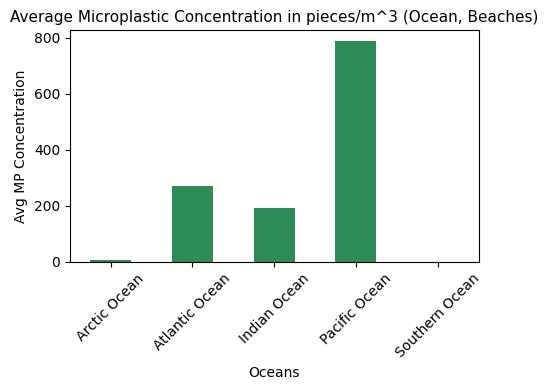

Top 3 Regions in each Ocean with highest Microplastic Concentration (pieces/m^3)


Oceans,Regions,Measurement
Arctic Ocean,Greenland Sea,32.080582
Arctic Ocean,White Sea,0.747836
Arctic Ocean,Kara Sea,0.483843


Oceans,Regions,Measurement
Atlantic Ocean,Gulf of Mexico,593.021599
Atlantic Ocean,Skagerrak Strait,36.001939
Atlantic Ocean,Kattegat,12.605566


Oceans,Regions,Measurement
Indian Ocean,Bay of Bengal,640.084756
Indian Ocean,Laccadive Sea,0.262925
Indian Ocean,Andaman Sea,0.095472


Oceans,Regions,Measurement
Pacific Ocean,Gulf of Thailand,48025.600067
Pacific Ocean,Eastern China Sea,10220.000000
Pacific Ocean,Tokyo Bay,3510.000000




Average Microplastic Concentration in pieces/kg-1 d.w. (Ocean Sediments)


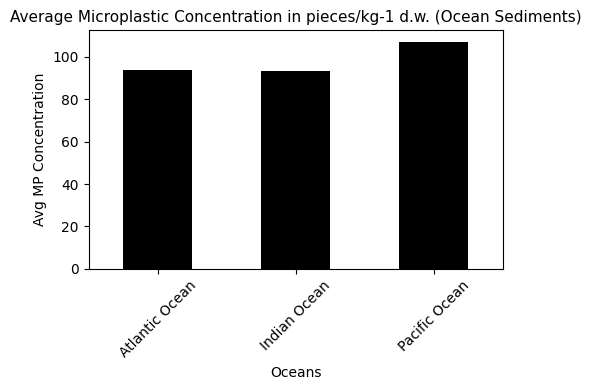

Top 3 Regions in each Ocean with highest Microplastic Concentration (pieces/kg-1 d.w.)


Oceans,Regions,Measurement
Atlantic Ocean,Irish Sea and St. George's Channel,59.666667
Atlantic Ocean,Celtic Sea,16.225000


Oceans,Regions,Measurement
Indian Ocean,Bay of Bengal,115.000000
Indian Ocean,Laccadive Sea,79.756944


Oceans,Regions,Measurement
Pacific Ocean,East China Sea,107.193270


In [8]:
# Average MP concentration across the Oceans and Beaches in the form of solid sediments or in the water. 

print("Average Microplastic Concentration in pieces/m^3 (Ocean, Beaches)\n")
mean_dfw = df_in_water.groupby(['Oceans', 'Regions'])['Measurement'].mean()
top3_dfw = mean_dfw.reset_index().sort_values(['Oceans', 'Measurement'], ascending=[True, False]).groupby('Oceans').head(3)

plt.figure(figsize=(5, 4))
df_in_water.groupby('Oceans')['Measurement'].mean().plot(kind='bar', color='seagreen')
plt.title("Average Microplastic Concentration in pieces/m^3 (Ocean, Beaches)", fontsize=11)
plt.xlabel("Oceans")
plt.ylabel("Avg MP Concentration")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Top 3 Regions in each Ocean with highest Microplastic Concentration (pieces/m^3)")
groups = top3_dfw.groupby('Oceans')
for ocean, g in groups:
    g1=g.style.background_gradient(subset=['Measurement'], cmap='PuBuGn').hide(axis='index')
    display(g1)

print("\n\nAverage Microplastic Concentration in pieces/kg-1 d.w. (Ocean Sediments)")
mean_dfs=df_in_solid.groupby(['Oceans', 'Regions'])['Measurement'].mean()
top3_dfs=mean_dfs.reset_index().sort_values(['Oceans', 'Measurement'], ascending=[True, False]).groupby('Oceans').head(3)

plt.figure(figsize=(5, 4))
df_in_solid.groupby(['Oceans'])['Measurement'].mean().plot(kind='bar', color='black')
plt.title("Average Microplastic Concentration in pieces/kg-1 d.w. (Ocean Sediments)", fontsize=11)
plt.xlabel("Oceans")
plt.ylabel("Avg MP Concentration")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Top 3 Regions in each Ocean with highest Microplastic Concentration (pieces/kg-1 d.w.)")
groups = top3_dfs.groupby('Oceans')
for ocean, g in groups:
    g1=g.style.background_gradient(subset=['Measurement'], cmap='magma').hide(axis='index')
    display(g1)

#df.head()

Inference :  There is a higher concentration of Microplastic debri in the Pacific Ocean, with an average of 7066.26 pieces/m^3 in the water and an average of 107.19 pieces/kg-1 d.w. in the form of Solid, Oceanic sediments. (You can convert this to a code cell and display ocean and region names as well.)

In [9]:
#Correlation Matrix - MP density with Microplastic's material density, latitude and longitude. 

def categorize_correlation(r):
    if abs(r) == 1:
        return "Perfect Correlation"
    elif 0.9 <= abs(r) < 1.0:
        return "Very High Correlation"
    elif 0.7 <= abs(r) < 0.9:
        return "High Correlation"
    elif 0.5 <= abs(r) < 0.7:
        return "Moderate Correlation"
    elif 0.3 <= abs(r) < 0.5:
        return "Low Correlation"
    elif 0.0 <= abs(r) < 0.3:
        return "Negligible Correlation"
    else:
        return "No Correlation"
    
corr_matrix = df[['Measurement', 'Median Density', 'Latitude', 'Longitude']].corr()
corr_df = corr_matrix['Measurement'].reset_index()
corr_df.columns = ['Variable', 'Correlation Coefficient']
for i in range(1,len(corr_df.index)):
    m,l = corr_df.iloc[i]
    print(f"{m} has {categorize_correlation(l)} with Microplastic Density")

#df.head()

Median Density has Moderate Correlation with Microplastic Density
Latitude has Negligible Correlation with Microplastic Density
Longitude has Negligible Correlation with Microplastic Density


###### #%history - f <filename.py> to save the py code. 

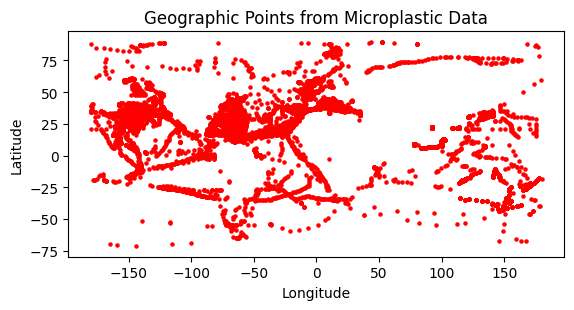

View the interative map in microplastic_footprint.html


In [10]:
# GEOSPATIAL ANALYSIS 

# check for latitude and longitude accuracy 

df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

# check for validity of coordinate ranges
df = df[(df['Latitude'] >= -90) & (df['Latitude'] <= 90)]
df = df[(df['Longitude'] >= -180) & (df['Longitude'] <= 180)]

# 1. GEOGRAPHIC DATA PREPARATION 

# create geometry point (remember they're essentialy tuple pairs)
geometry =[]
for P in zip(df['Longitude'], df['Latitude']):
    geometry.append(Point(P))

# now that you have created a geomtery variable (which is a list of Points), 
# you can use this as an input parameter to convert your Pandas dataframe to a GeoPandas dataframe. 
# This will be a replacement for a .shp file 
# (since you already have 'Latitude' and 'Longitude' defined, you don't need polygon or line data from country boundaries and regions). 

gdf = gpd.GeoDataFrame(df, geometry=geometry)

# now you need to set CRS - coordinate reference system, because until you do this, gdf Points refer to an arbitrary space. 
# CRS defines how the points relate to places on Earth

gdf.set_crs(epsg=4326, inplace=True)
gdf.to_file("microplastic_data.geojson", driver="GeoJSON")

gdf.plot(marker='o', color='red', markersize=5)  # Adjust 'o' for circle, 'r' for color, and size as needed
plt.title("Geographic Points from Microplastic Data")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# 2. SPATIAL DISTRIBUTION

# use folium to create an interative map showing MP spread.  
cen_lat = gdf['geometry'].y.mean()
cen_long = gdf['geometry'].x.mean()
m = folium.Map(location=[cen_lat,cen_long], tiles='OpenStreetMap', zoom_start=3)
#folium.GeoJson(world).add_to(m)
m.save("footprint.html")


gdf['LogMeasurement'] = np.log1p(gdf['Measurement']) # to represent larger variations in the measurement data. 

def colormaps(marine_setting, list_color, measure_type):
    gdf_filter = gdf[gdf['Marine Setting']==marine_setting]
    colormap = LinearColormap(
    colors=list_color,
    vmin=gdf_filter[measure_type].min(),             # Minimum value for the gradient
    vmax=gdf_filter[measure_type].max(),             # Maximum value for the gradient      
    ).to_step(10)
    return colormap

# To mark sample collection points measured in pieces/m^3 (Ocean)
colormap_circle = colormaps("Ocean",  ['#a6bddb','#74a9cf','#3690c0','#0570b0','#034e7b'], "LogMeasurement")
# To mark sample collection points measured in pieces/m^3 (Beach)
colormap_hex = colormaps("Beach", ['#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177'], "LogMeasurement")
#To mark sample collection points measured in pieces/kg-1 d.w. (Ocean Sediment)
colormap_square = colormaps("Ocean Sediment", ['#fec44f','#fe9929', '#ec7014', '#cc4c02','#8c2d04'], "LogMeasurement")

for lat, lon, measurement, marine_setting in zip(gdf.geometry.y, gdf.geometry.x, gdf['Measurement'], gdf['Marine Setting']):
    if marine_setting == 'Ocean':
        folium.Marker(
            location=[lat, lon],
            icon=folium.DivIcon(
                html=f"""
                <div style="
                    background-color: {colormap_circle(measurement)};
                    width: 12px;
                    height: 12px;
                    border-radius: 50%;
                    border: 0.3px solid black;  
                    ">
                </div>"""
            ),
            popup=f"Measurement: {measurement}"
        ).add_to(m)
    elif marine_setting == 'Ocean Sediment':
        folium.Marker(
            location=[lat, lon],
            icon=folium.DivIcon(
                html=f"""
                <div style="
                    background-color: {colormap_square(measurement)};
                    width: 12px;
                    height: 12px;
                    border: 0.3px solid black;">
                </div>"""  # Square shape (no border-radius)
            ),
            popup=f"Measurement: {measurement}"
        ).add_to(m)
    else:
        folium.Marker(
            location=[lat, lon],
            icon=folium.DivIcon(
                html=f"""
                <div style="
                    width: 16px;
                    height: 16px;
                    background-color: {colormap_hex(measurement)};
                    clip-path: polygon(50% 0%, 100% 25%, 100% 75%, 50% 100%, 0% 75%, 0% 25%);
                    border: 0.3px solid black;">
                </div>"""
            ),
            popup=f"Measurement: {measurement}"
        ).add_to(m)

c = colormaps("Ocean",  ['#a6bddb','#74a9cf','#3690c0','#0570b0','#034e7b'], "Measurement")
c.caption = "Ocean (pieces/m^3)"
c.add_to(m)
h = colormaps("Beach", ['#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177'], "Measurement")
h.caption = "Beach (pieces/m^3)"
h.add_to(m)
s = colormaps("Ocean Sediment", ['#fec44f','#fe9929', '#ec7014', '#cc4c02','#8c2d04'], "Measurement") 
s.caption = "Ocean Sediments (pieces/kg-1 d.w.)"
s.add_to(m)
m.save("microplastic_footprint.html")
#m

print("View the interative map in microplastic_footprint.html")
#df.head()


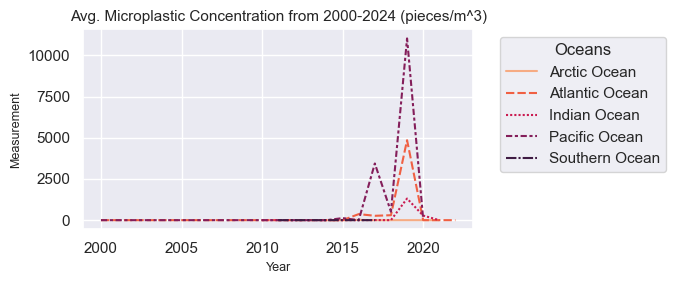

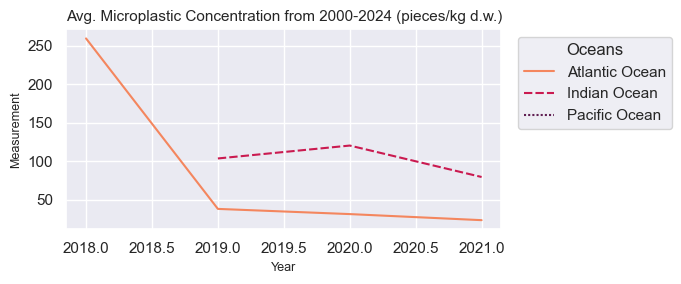

In [11]:
# 3. TEMPORAL ANALYSIS

# Yearly avg MP distribution in Marine Settings. 
df1 = df[df['Unit']=="pieces/m3"]
yearly_data1 = df1.groupby(['Year', 'Oceans'])['Measurement'].mean().reset_index()
pivot_data1 = yearly_data1.pivot_table(index='Year', columns='Oceans', values='Measurement')

plt.figure(figsize=(7, 3))  # Create a new figure for the first plot
sns.set_theme(style="darkgrid")
sns.lineplot(data=pivot_data1, palette="rocket_r", linewidth=1.5)
plt.title('Avg. Microplastic Concentration from 2000-2024 (pieces/m^3)', fontsize=11)
plt.xlabel('Year', fontsize=9)
plt.ylabel('Measurement', fontsize=9)
plt.legend(title="Oceans", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


df2 = df[df['Unit']=='pieces kg-1 d.w.']
yearly_data2= df2.groupby(['Year', 'Oceans'])['Measurement'].mean().reset_index()
pivot_data2 = yearly_data2.pivot_table(index='Year', columns='Oceans', values='Measurement')

plt.figure(figsize=(7, 3))  # Create a new figure for the second plot
sns.set_theme(style="darkgrid")
sns.lineplot(data=pivot_data2, palette="rocket_r", linewidth=1.5)
plt.title('Avg. Microplastic Concentration from 2000-2024 (pieces/kg d.w.)', fontsize=11)
plt.xlabel('Year', fontsize=9)
plt.ylabel('Measurement', fontsize=9)
plt.legend(title="Oceans", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

#df.head()

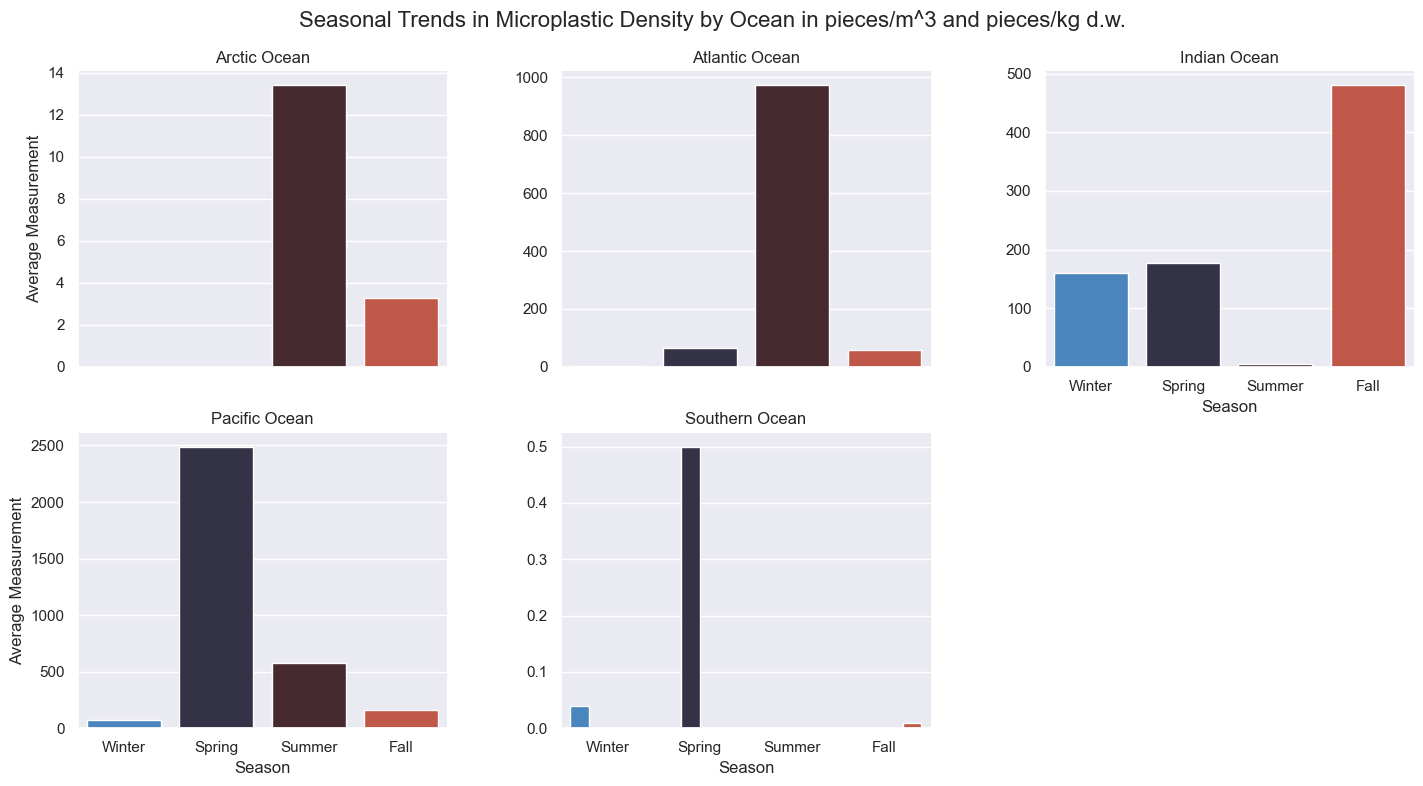

In [12]:
# Seasonal Distribution 

df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Season'] = df['Month'].map({12: 'Winter', 1: 'Winter', 2: 'Winter',
                                 3: 'Spring', 4: 'Spring', 5: 'Spring',
                                 6: 'Summer', 7: 'Summer', 8: 'Summer',
                                 9: 'Fall', 10: 'Fall', 11: 'Fall'})
seasonal_data = df.groupby(['Season', 'Oceans'])['Measurement'].mean().reset_index()

'''sns.barplot(data=seasonal_data, x='Season', y='Measurement', hue='Oceans', palette="icefire")
plt.title('Seasonal Microplastic Concentrations')
plt.show()'''

# Sort seasons in order
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
seasonal_data['Season'] = pd.Categorical(seasonal_data['Season'], categories=season_order, ordered=True)

g = sns.FacetGrid(seasonal_data, col="Oceans", col_wrap=3, height=4, sharey=False, aspect=1.2)
g.map(sns.barplot, "Season", "Measurement", data=seasonal_data, order=season_order, palette="icefire", hue="Season", legend=False)

g.set_titles("{col_name}")
g.set_axis_labels("Season", "Average Measurement")
g.figure.subplots_adjust(top=0.9)  # Adjust space to add a common title
g.figure.suptitle("Seasonal Trends in Microplastic Density by Ocean in pieces/m^3 and pieces/kg d.w.", fontsize=16)
g.figure.tight_layout(w_pad=4)
plt.show()

#df.head()

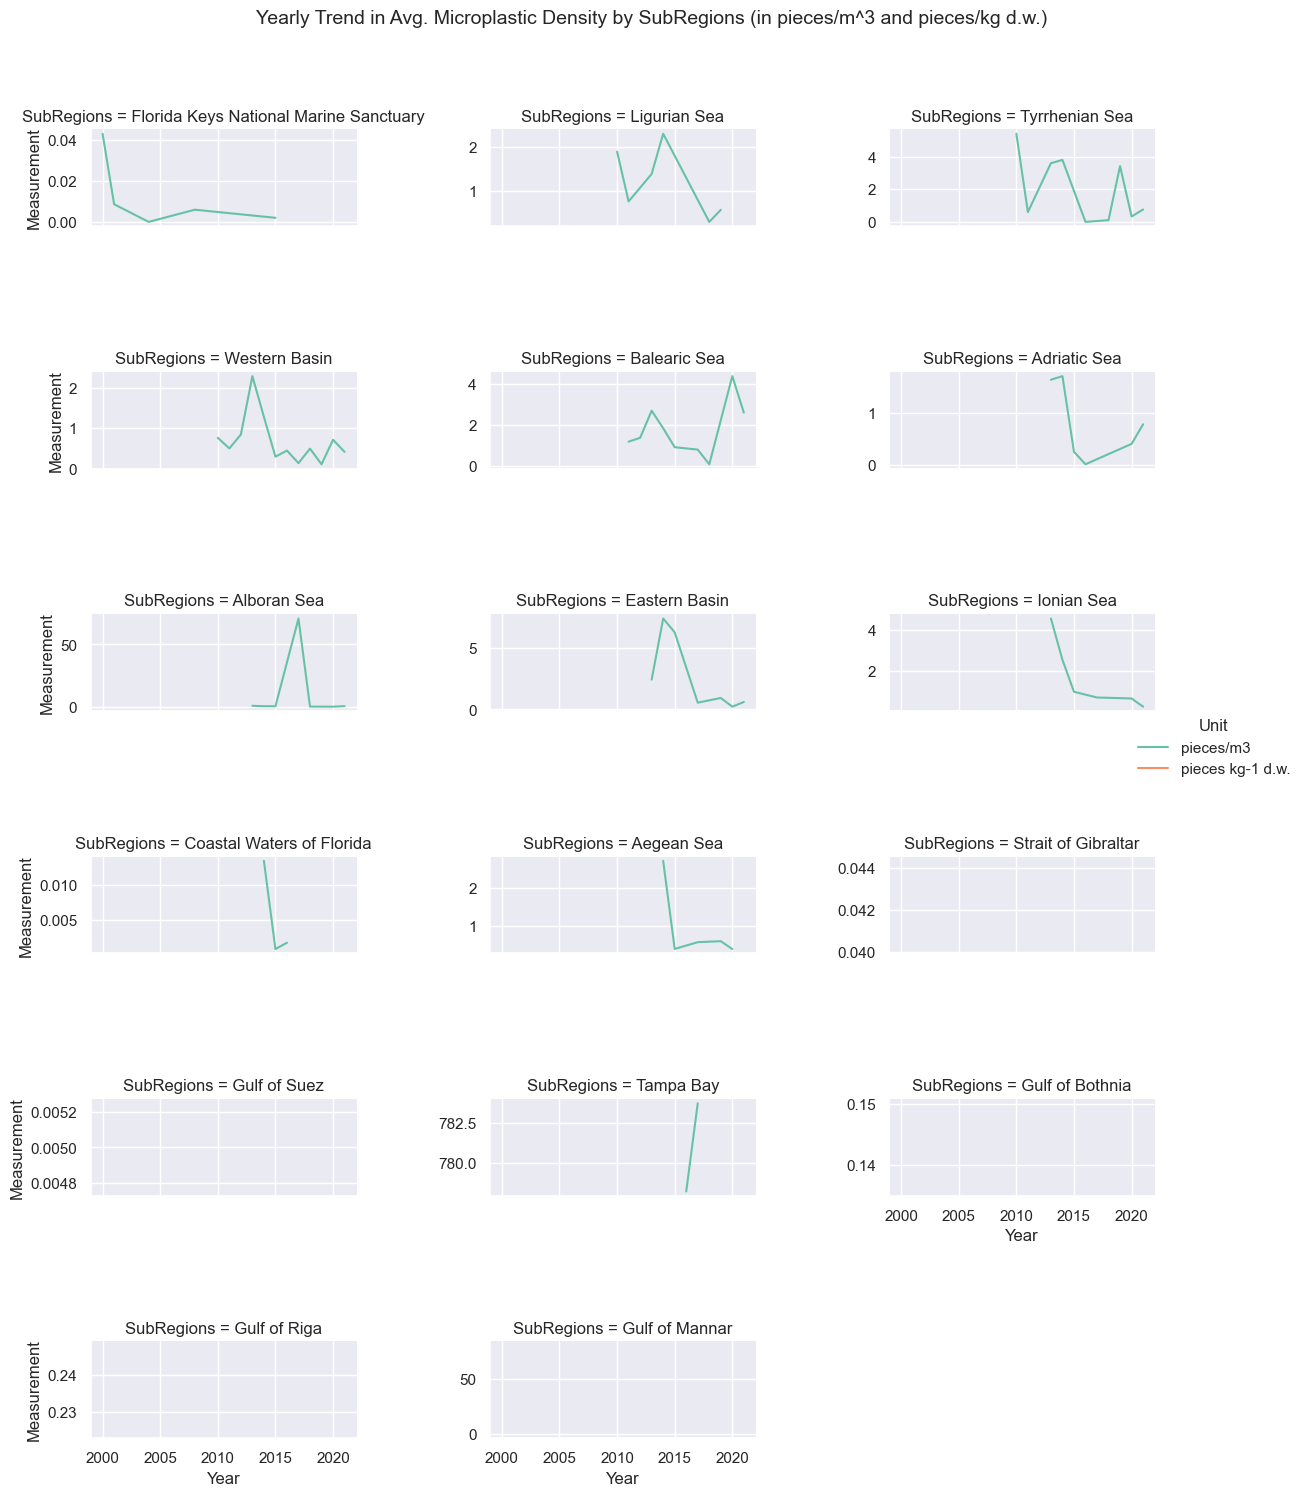

In [13]:
# yearly distribution by subregions

# Group the data and calculate mean measurements
df_subregions = df.groupby(['Year', 'Oceans', 'Regions', 'SubRegions', 'Unit'])['Measurement'].mean().reset_index()

grid = sns.FacetGrid(df_subregions, col="SubRegions", col_wrap=3, height=4, sharey=False, aspect=1.2)

grid.map(sns.lineplot, "Year", "Measurement", hue="Unit", palette="Set2", data=df_subregions)


grid.add_legend(title="Unit")


grid.figure.set_size_inches(13, 15)
grid.figure.subplots_adjust(top=0.9, hspace=1.5, wspace=0.5)  # Adjust top for title and spacing between plots
grid.figure.suptitle("Yearly Trend in Avg. Microplastic Density by SubRegions (in pieces/m^3 and pieces/kg d.w.)", fontsize=14)

plt.show()

#df.head()

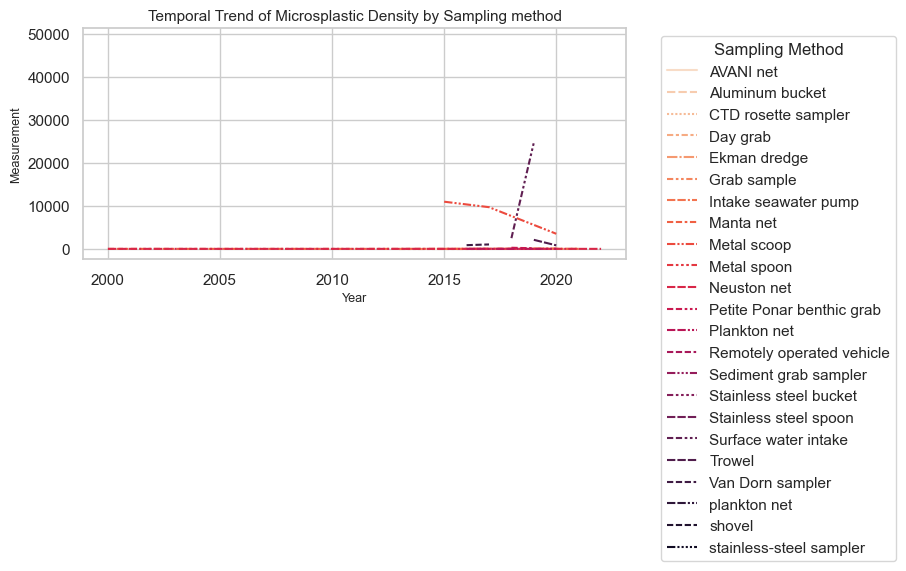

In [14]:
# Compare Density trends by Sampling methods. / 
# create a heatmap... density class, sampling method, and measurement... 
# do this above and not in the temporal analysis section.  




sampling_data = df.groupby(['Year', 'Sampling Method'])['Measurement'].mean().reset_index()
pivot_data = sampling_data.pivot_table(index='Year', columns='Sampling Method', values='Measurement')

plt.figure(figsize=(7, 3))  # Create a new figure for the first plot
sns.set_theme(style="whitegrid")
sns.lineplot(data=pivot_data, palette="rocket_r", linewidth=1.5)
plt.title('Temporal Trend of Microsplastic Density by Sampling method', fontsize=11)
plt.xlabel('Year', fontsize=9)
plt.ylabel('Measurement', fontsize=9)
plt.legend(title="Sampling Method", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()



18:00:15 - cmdstanpy - INFO - Chain [1] start processing
18:00:16 - cmdstanpy - INFO - Chain [1] done processing


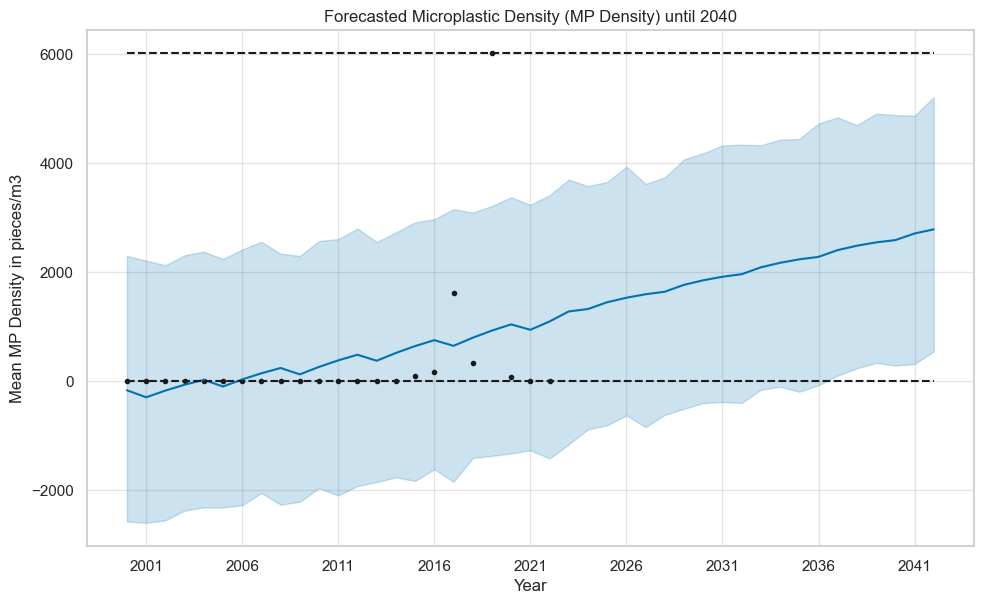

18:00:16 - cmdstanpy - INFO - Chain [1] start processing
18:00:16 - cmdstanpy - INFO - Chain [1] done processing


The predicted mean Microplastic density in the year 2040 is 2703.05


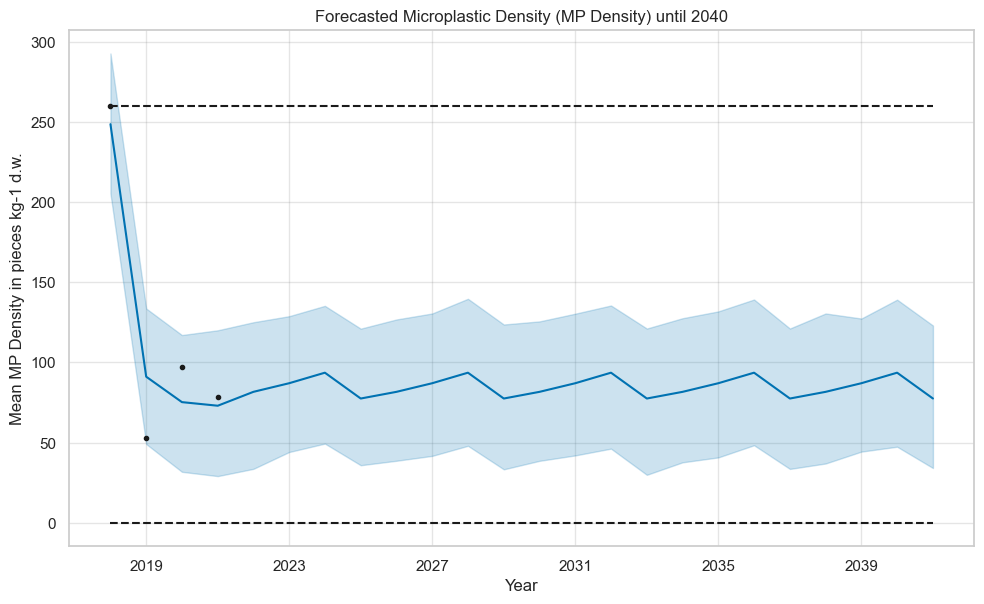

The predicted mean Microplastic density in the year 2040 is 77.48


In [15]:
# 3.2 TIME SERIES ANALYSIS - USING ARIMA, Prophet, or LSTM (??)



def future_forecast(df, unit_value):
    df_filtered = df[df['Unit'] == unit_value]
    dfmodel = df_filtered
    #df_prophet = dfmodel.drop(columns=dfmodel.columns.difference(['Year', 'Measurement']), axis=1, inplace=True)
    df_prophet = dfmodel[['Year', 'Measurement']].groupby('Year').mean().reset_index()
    df_prophet = df_prophet.rename(columns={'Year': 'ds', 'Measurement': 'y'})
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')
    
    df_prophet['cap'] = df_prophet['y'].max()  
    df_prophet['floor'] = 0 

    #m = Prophet(interval_width=0.95, daily_seasonality=True)
    m = Prophet(growth='logistic', interval_width=0.95)
    m.fit(df_prophet)

    future_prophet = m.make_future_dataframe(periods=20, freq='Y')
    future_prophet['cap'] = df_prophet['cap'].iloc[0]  
    future_prophet['floor'] = 0                        

    forecast= m.predict(future_prophet)

    fig = m.plot(forecast)
    plt.title("Forecasted Microplastic Density (MP Density) until 2040")
    plt.xlabel("Year")
    plt.ylabel(f"Mean MP Density in {unit_value}")
    plt.show()


    # Display forecast for 2040
    forecast_2040 = forecast[forecast['ds'].dt.year == 2040]
    forecast_2040 = forecast_2040.reset_index(drop=True)
    print(f"The predicted mean Microplastic density in the year 2040 is {round(forecast_2040['yhat'].iloc[0],2)}")

future_forecast(df, 'pieces/m3')
future_forecast(df, 'pieces kg-1 d.w.')







In [16]:
# Forecasting using ARIMA
#